In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# https://github.com/mwalmsley/curation-datasets/blob/main/notebooks/curation_friendly_gz2_catalog.ipynb
# gz2 with class labels
# (also exists for decals)

In [108]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

from zoobot.shared import label_metadata, schemas

In [109]:


question_answer_pairs = label_metadata.gz2_pairs
dependencies = label_metadata.gz2_and_decals_dependencies
schema = schemas.Schema(question_answer_pairs, dependencies)



In [110]:
# df = pd.read_csv('/run/media/walml/beta/galaxy_zoo/gz2/subjects/gz2_hart16.csv')
# df = pd.read_csv('/run/media/walml/beta/galaxy_zoo/gz2/subjects/gz2_classifications_and_subjects.csv')
df = pd.read_parquet('/run/media/walml/beta/galaxy_zoo/gz2/subjects/gz2_catalog_with_modern_schema.parquet')

In [111]:
len(df)

209293

In [112]:
df.head()

,dr7objid,png_loc,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_artifact,disk-edge-on_yes,disk-edge-on_no,bar_yes,bar_no,has-spiral-arms_yes,...,spiral-winding_medium_fraction,spiral-winding_loose_fraction,spiral-arm-count_total-votes,spiral-arm-count_1_fraction,spiral-arm-count_2_fraction,spiral-arm-count_3_fraction,spiral-arm-count_4_fraction,spiral-arm-count_more-than-4_fraction,spiral-arm-count_cant-tell_fraction,file_loc
0,587732591714893851,/raid/scratch/walml/galaxy_zoo/gz2/png/587732/...,0,42,3,2,40,1,39,40,...,0.300000,0.02500,40,0.0,0.075000,0.02500,0.05000,0.450000,0.400000,/run/media/walml/beta/galaxy_zoo/gz2/png/58773...
1,588009368545984617,/raid/scratch/walml/galaxy_zoo/gz2/png/588009/...,1,41,0,0,41,4,37,41,...,0.097561,0.04878,41,0.0,0.097561,0.04878,0.02439,0.512195,0.317073,/run/media/walml/beta/galaxy_zoo/gz2/png/58800...
2,587732484359913515,/raid/scratch/walml/galaxy_zoo/gz2/png/587732/...,28,5,3,0,5,2,3,0,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,/run/media/walml/beta/galaxy_zoo/gz2/png/58773...
3,587741723357282317,/raid/scratch/walml/galaxy_zoo/gz2/png/587741/...,1,27,0,1,26,1,25,25,...,0.320000,0.04000,25,0.0,0.080000,0.24000,0.20000,0.240000,0.240000,/run/media/walml/beta/galaxy_zoo/gz2/png/58774...
4,587738410866966577,/raid/scratch/walml/galaxy_zoo/gz2/png/587738/...,33,8,2,1,7,0,7,0,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,/run/media/walml/beta/galaxy_zoo/gz2/png/58773...


In [113]:
df['smooth-or-featured_featured-or-disk']

0         42
1         41
2          5
3         27
4          8
          ..
209288    12
209289    13
209290     8
209291     0
209292     3
Name: smooth-or-featured_featured-or-disk, Length: 209293, dtype: int64

In [114]:
# adapted from https://github.com/mwalmsley/galaxy_mnist/blob/main/reproduce/consider_classes.ipynb

def get_question_semantic_label(galaxy, question, min_relevance_threshold=0.5, min_confidence_threshold=0.5):
    
    if question.asked_after is not None:
        # at least ``min_relevance_threshold`` of volunteers must have gone down this path, else consider unknown (-)
        has_enough_answers = galaxy[question.asked_after.text] > galaxy['smooth-or-featured_total-votes'] * min_relevance_threshold
        if not has_enough_answers:
            return '-'
    
    answer_cols = [a.text for a in question.answers]
    
    # check for deadlock
    sorted_answers = np.sort(galaxy[answer_cols])  # ascending
    if sorted_answers[-1] == sorted_answers[-2]:
        return 'deadlock'

    highest_conf_answer = np.argmax(galaxy[answer_cols])  # if tiebreak, will default to the first
    # of the volunteers who did go down this path, at least min_confidence_threshold must have given this answer
    if galaxy[answer_cols[highest_conf_answer] + '_fraction'] > min_confidence_threshold:
        return answer_cols[highest_conf_answer]
    else:
        return 'unclear'



In [115]:
galaxy = df.iloc[0]

for question in schema.questions:
    print(question.text, get_question_semantic_label(galaxy, question))

smooth-or-featured smooth-or-featured_featured-or-disk
disk-edge-on disk-edge-on_no
has-spiral-arms has-spiral-arms_yes
bar bar_no
bulge-size bulge-size_just-noticeable
something-odd something-odd_no
how-rounded -
bulge-shape -
spiral-winding spiral-winding_tight
spiral-arm-count unclear


In [116]:
sample = df.sample(5000)

for question in schema.questions:
    sample[question.text + '_semantic'] = sample.apply(lambda x: get_question_semantic_label(x, question, min_relevance_threshold=0.5, min_confidence_threshold=0.), axis=1)

In [117]:


key_questions = ['smooth-or-featured', 'how-rounded', 'disk-edge-on', 'has-spiral-arms', 'bar']

sample['temp_semantic_label'] = sample.apply(lambda galaxy: ' '.join(galaxy[[col + '_semantic' for col in key_questions]]), axis=1)

sample['temp_semantic_label'].value_counts()[:20]

# smooth-or-featured_smooth - - - - is possible because of artifact: one can be mode smooth, but have less have half answer smooth



smooth-or-featured_smooth how-rounded_in-between - - -                                1885
smooth-or-featured_smooth how-rounded_round - - -                                     1335
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_no       605
smooth-or-featured_smooth how-rounded_cigar - - -                                      451
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_yes      236
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_no bar_no         97
smooth-or-featured_featured-or-disk - disk-edge-on_yes deadlock deadlock                67
smooth-or-featured_smooth - - - -                                                       55
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_no bar_yes        48
smooth-or-featured_smooth deadlock - - -                                                40
smooth-or-featured_featured-or-disk - - - -                                             38

In [118]:


semantic_to_summary = {
    'smooth-or-featured_smooth how-rounded_round - - -': 'smooth_round',
    'smooth-or-featured_smooth how-rounded_in-between - - -': 'smooth_inbetween',
    'smooth-or-featured_smooth how-rounded_cigar - - -': 'smooth_cigar',
    'smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_no': 'unbarred_spiral',
    'smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_yes': 'barred_spiral',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes - -': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_no bar_no': 'featured_without_bar_or_spiral',
    # call all of these edge-on disk, regardless of further answers
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes deadlock deadlock': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes has-spiral-arms_yes bar_no': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes has-spiral-arms_yes bar_yes': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes has-spiral-arms_yes bar_no': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes has-spiral-arms_no bar_yes': 'edge_on_disk',
}
sample['summary'] = sample['temp_semantic_label'].apply(lambda x: semantic_to_summary.get(x, None))

sample['summary'].value_counts()



smooth_inbetween                  1885
smooth_round                      1335
unbarred_spiral                    605
smooth_cigar                       451
barred_spiral                      236
edge_on_disk                       103
featured_without_bar_or_spiral      97
Name: summary, dtype: int64

In [119]:
# sample[sample['temp_semantic_label'] == "smooth-or-featured_smooth - - - -"]
# sample[sample['temp_semantic_label'] == "smooth-or-featured_featured-or-disk - disk-edge-on_yes deadlock deadlock"]['summary']

### Apply to whole dataset (6 mins)

In [121]:
# takes about 5 minutes for the full dataset
for question in schema.questions:
    df[question.text + '_semantic'] = df.apply(lambda x: get_question_semantic_label(x, question, min_relevance_threshold=0.5, min_confidence_threshold=0.), axis=1)

In [122]:
# takes about 35 seconds

key_questions = ['smooth-or-featured', 'how-rounded', 'disk-edge-on', 'has-spiral-arms', 'bar']

df['temp_semantic_label'] = df.apply(lambda galaxy: ' '.join(galaxy[[col + '_semantic' for col in key_questions]]), axis=1)

df['temp_semantic_label'].value_counts()[:20]

smooth-or-featured_smooth how-rounded_in-between - - -                                78460
smooth-or-featured_smooth how-rounded_round - - -                                     54997
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_no      26132
smooth-or-featured_smooth how-rounded_cigar - - -                                     19734
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_yes      9246
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_no bar_no        4295
smooth-or-featured_featured-or-disk - disk-edge-on_yes deadlock deadlock               2753
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_no bar_yes       2073
smooth-or-featured_smooth - - - -                                                      1918
smooth-or-featured_featured-or-disk - - - -                                            1688
smooth-or-featured_featured-or-disk - disk-edge-on_yes has-spiral-arms_no bar_no

In [123]:
df['summary'] = df['temp_semantic_label'].apply(lambda x: semantic_to_summary.get(x, None))

df['summary'].value_counts()


smooth_inbetween                  78460
smooth_round                      54997
unbarred_spiral                   26132
smooth_cigar                      19734
barred_spiral                      9246
edge_on_disk                       4613
featured_without_bar_or_spiral     4295
Name: summary, dtype: int64

In [124]:
# leaf probability

# could do this programatically, but can code up manually pretty easily

leaf_prob_cols_to_multiply = {
    'smooth_inbetween': ['smooth-or-featured_smooth_fraction', 'how-rounded_in-between_fraction'],
    'smooth_round': ['smooth-or-featured_smooth_fraction', 'how-rounded_round_fraction'],
    'smooth_cigar': ['smooth-or-featured_smooth_fraction', 'how-rounded_cigar_fraction'],
    'edge_on_disk': ['smooth-or-featured_featured-or-disk_fraction', 'disk-edge-on_yes_fraction'],
    'unbarred_spiral': ['smooth-or-featured_featured-or-disk_fraction', 'disk-edge-on_no_fraction', 'has-spiral-arms_yes_fraction', 'bar_no_fraction'],
    'barred_spiral': ['smooth-or-featured_featured-or-disk_fraction', 'disk-edge-on_no_fraction', 'has-spiral-arms_yes_fraction', 'bar_yes_fraction'],
    'featured_without_bar_or_spiral': ['smooth-or-featured_featured-or-disk_fraction', 'disk-edge-on_no_fraction', 'has-spiral-arms_no_fraction', 'bar_no_fraction'],
    None: []
}

def get_leaf_prob(galaxy):
    cols_to_multiply = leaf_prob_cols_to_multiply[galaxy['summary']]
    return np.prod(galaxy[cols_to_multiply])  # np.prod(galaxy[[]])  # defaults to 1

df['leaf_prob'] = df.apply(get_leaf_prob, axis=1)

df[['summary', 'leaf_prob']]



,summary,leaf_prob
0,unbarred_spiral,0.866667
1,unbarred_spiral,0.880952
2,smooth_inbetween,0.638889
3,unbarred_spiral,0.858516
4,smooth_round,0.418605
...,...,...
209288,smooth_cigar,0.700000
209289,smooth_round,0.428571
209290,smooth_round,0.500000
209291,smooth_inbetween,0.700000


(array([  452.,  3191.,  9243., 19101., 33697., 36538., 36881., 35392.,
        20208., 14590.]),
 array([0.08990011, 0.1809101 , 0.27192009, 0.36293008, 0.45394007,
        0.54495006, 0.63596004, 0.72697003, 0.81798002, 0.90899001,
        1.        ]),
 <BarContainer object of 10 artists>)

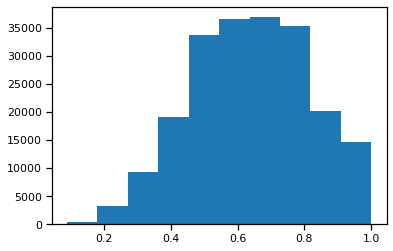

In [125]:
plt.hist(df['leaf_prob'])

<AxesSubplot:xlabel='leaf_prob', ylabel='Density'>

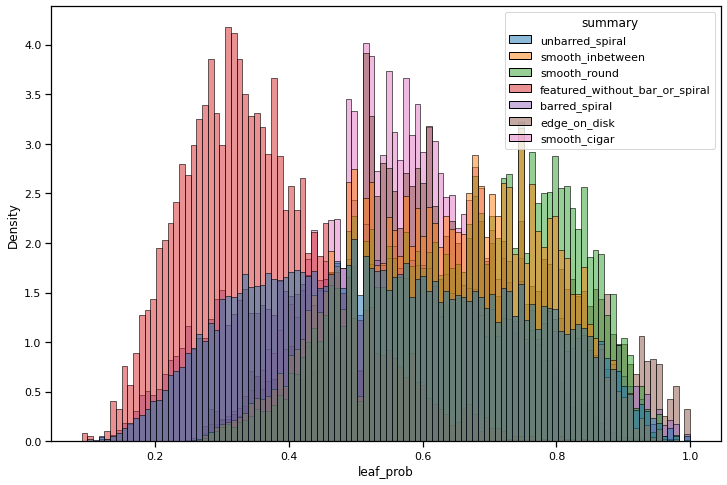

In [126]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=df, hue='summary', x='leaf_prob', ax=ax, stat='density', common_norm=False, common_bins=True)

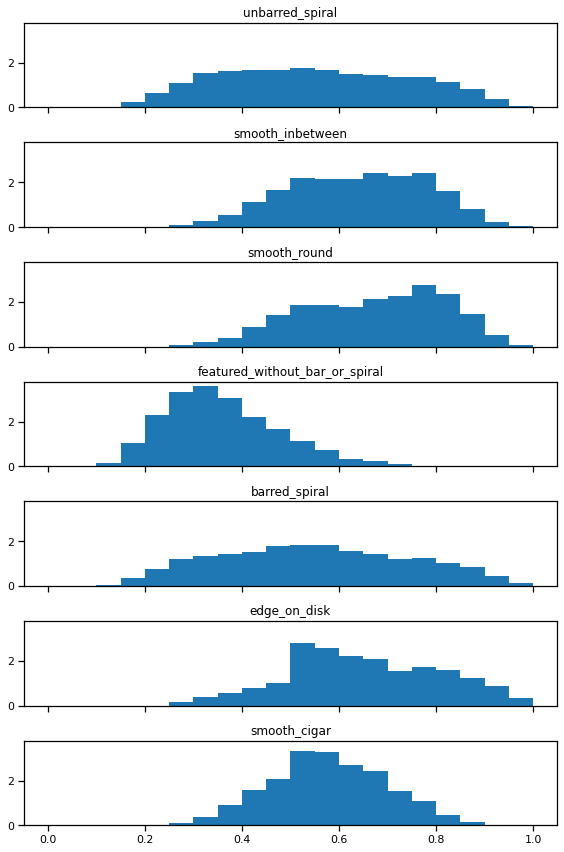

In [127]:
fig, axes = plt.subplots(figsize=(8, 12), nrows=7, sharex=True, sharey=True)
_, bins = np.histogram(np.linspace(0., 1.), bins=20)

for leaf_n, leaf in enumerate(df['summary'].dropna().unique()):
    
    ax = axes[leaf_n]

    leaf_probs = df.query(f'summary == "{leaf}"')['leaf_prob']
    ax.hist(leaf_probs, bins=bins, density=True)

    ax.set_title(leaf)

fig.tight_layout()

In [ ]:


summary_to_class_index = {
    'smooth_inbetween': 0,
    'smooth_round': 1,
    'smooth_cigar': 2,
    'edge_on_disk': 3,
    'unbarred_spiral': 4,
    'barred_spiral': 5,
    'featured_without_bar_or_spiral': 6
}

df['label'] = df['summary'].apply(lambda x: summary_to_class_index.get(x, -1)).astype(int)  # be sure to drop -1's. Keeping here for dtype (nan is float)

df['label'].value_counts()



     


In [128]:
df.to_parquet('gz2_with_leafs.parquet')

You can see how changing curation will change the class balance: first will drop misc-featured, then spirals, then smooth-cigar, then the rest